In [2]:
import os
from pathlib import Path
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

mwb_flow_dir = r'C:\Users\CND905\Downloaded_Programs\mwb_flow'
os.chdir(mwb_flow_dir)

from mwb_flow.model import WB_Model

Initializing mwb_flow module.


In [2]:
data = xr.load_dataset(r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples\dataprep_Example1.1_PullData_output.nc')
data

<xarray.Dataset> Size: 7kB
Dimensions:       (location: 6, time: 48)
Coordinates:
  * location      (location) int64 48B 1000 2800 3000 5500 9500 9600
  * time          (time) datetime64[ns] 384B 2016-01-01 ... 2019-12-01
    lat           (location) float64 48B 46.7 46.82 46.78 46.67 46.75 46.75
    area          (location) float64 48B 185.3 34.26 186.8 139.0 102.1 57.96
Data variables:
    mo_temp       (time, location) float64 2kB -3.117 -2.624 ... -2.265 -1.994
    mo_precip     (time, location) float64 2kB 114.4 76.8 65.13 ... 62.7 47.3
    mo_discharge  (time, location) float64 2kB 12.89 nan nan ... 50.06 78.89
Attributes:
    standard_name:  Monthly_Temperature
    units:          Celcius

In [ ]:
model_result = WB_Model(data_arr = data, init_per=12, soil_stor_cap=60, temp_sno=-5, temp_rain=5, dr_frac=0.06, mlt_rate=0.6, sr_factor=0.5).run_model()
model_result['total_runoff'].values

In [ ]:
model = WB_Model(data_arr = data, init_per=12, soil_stor_cap=60, temp_sno=-5,
                 temp_rain=5, dr_frac=0.06, mlt_rate=0.6, sr_factor=0.5)
results = model.run_model()

watershed_index = 3 #S.Fork has no upstream water inputs
x = results['time'].values
y1 = model.val_Q[12:,watershed_index]
y2 = results['total_runoff'].values[:,watershed_index]

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Lolo Creek South Fork (76HB_05500)")
plt.ylabel("Monthly Runoff (mm)")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()

# Test

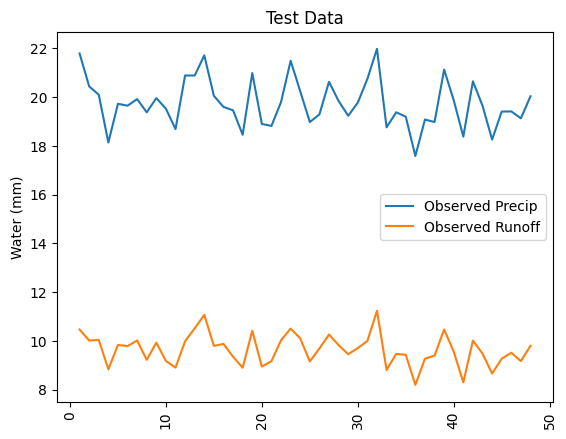

In [3]:
import random
np.random.seed(3)
months = 12 * 4
times = np.array(list(range(1, months + 1)))
obs_p = np.random.normal(loc=20, scale=1, size=months)
noise = np.random.normal(loc=0, scale=0.3, size=months)
real_runoff_frac = 0.6
real_ET_const = 2.2
obs_RO = ((obs_p + noise) * real_runoff_frac) - real_ET_const

x = times
y1 = obs_p
y2 = obs_RO
plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Test Data")
plt.ylabel("Water (mm)")
classes = ['Observed Precip', 'Observed Runoff']
plt.legend(labels=classes)
plt.show()

In [5]:
obs_RO

array([10.46849069, 10.01370877, 10.0402715 ,  8.83540799,  9.83304083,
        9.78863493, 10.01811287,  9.22250547,  9.92595911,  9.17870907,
        8.90316183,  9.98616846, 10.51745738, 11.06581665,  9.79448554,
        9.87662966,  9.35133308,  8.89922465, 10.41695069,  8.94780427,
        9.16780247, 10.02562618, 10.50720146, 10.10391068,  9.15791768,
        9.69073699, 10.26222888,  9.82541093,  9.45446758,  9.70681717,
        9.99579633, 11.23616579,  8.80680558,  9.46709123,  9.42827422,
        8.19772589,  9.27183617,  9.39589336, 10.47004797,  9.56089313,
        8.30119594, 10.01307398,  9.47984337,  8.66116025,  9.2692109 ,
        9.51475651,  9.17222311,  9.79812651])

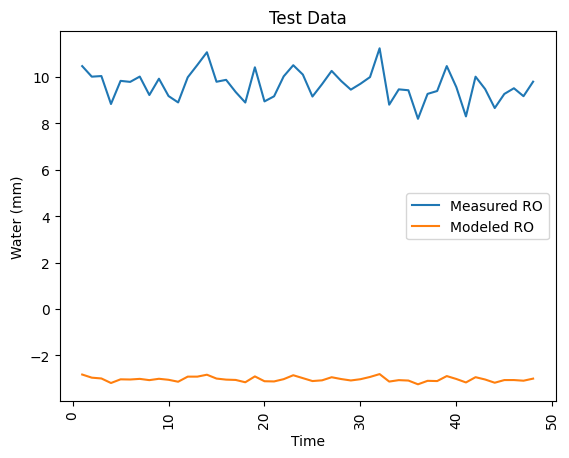

In [4]:
# Create the model class
class ModelT ():
    def __init__(self, p_arr, runoff_frac=0.1, ET_const=0.3):
        self.P = p_arr
        self.frac = runoff_frac
        self.ET = ET_const
    
    def _runmodel(self):
        pred_ro = self.P * self.frac - self.ET
        return pred_ro

# Run model class pretending that we dont know the actual runoff_fraction or ET_const value
x = times
y1 = obs_RO
y2 = ModelT(p_arr=obs_p, runoff_frac=0.1, ET_const=5)._runmodel()

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Test Data")
plt.ylabel("Water (mm)")
plt.xlabel("Time")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()

https://github.com/thouska/spotpy/blob/master/src/spotpy/objectivefunctions.py

In [11]:
# Create calibration spot_setup class

import spotpy
class Spot_Setup(object):
    def __init__(self, p_data, ro_data, func=None):

        self.params = [
            spotpy.parameter.Uniform("RO_fraction", low=0.01, high=0.99, optguess=0.1),
            spotpy.parameter.Uniform("ET_constant", low=0, high=10, optguess=5),
        ]

        self.precip = p_data
        self.runoff = ro_data
        
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    def simulation(self,x):
        #Here the model is actualy started with a unique parameter combination that it gets from spotpy for each time the model is called
        model_result = ModelT(p_arr=self.precip, runoff_frac=x[0], ET_const=x[1])._runmodel()
        sim=[]
        for val in model_result:
            sim.append(val)
        #The first year of simulation data is ignored (warm-up)
        return sim
    
    def evaluation(self):
        observations=self.runoff
        return observations
    
    def objectivefunction(self,simulation,evaluation):
        objectivefunction= -spotpy.objectivefunctions.rmse(evaluation,simulation)      
        return objectivefunction

In [ ]:
results=[]
spot_setup=Spot_Setup(obs_p, obs_RO)
rep=100000
timeout=10 #Given in Seconds

parallel = "seq"
dbformat = "csv"

sampler=spotpy.algorithms.mc(spot_setup,parallel=parallel, dbname='testMC', dbformat=dbformat, sim_timeout=timeout)
# print(describe(sampler))
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.lhs(spot_setup,parallel=parallel, dbname='testLHS', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.mle(spot_setup, parallel=parallel, dbname='testMLE', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.mcmc(spot_setup, parallel=parallel, dbname='testMCMC', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.sceua(spot_setup, parallel=parallel, dbname='testSCEUA', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep,ngs=4)
results.append(sampler.getdata())

sampler=spotpy.algorithms.sa(spot_setup, parallel=parallel, dbname='testSA', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

## Not sure why this one doesnt work
# sampler=spotpy.algorithms.demcz(spot_setup,parallel=parallel, dbname='testDEMCz', dbformat=dbformat, sim_timeout=timeout)
# sampler.sample(rep,nChains=4)
# results.append(sampler.getdata())

sampler=spotpy.algorithms.rope(spot_setup, parallel=parallel, dbname='testROPE',  dbformat=dbformat,sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.abc(spot_setup, parallel=parallel,   dbname='testABC',     dbformat=dbformat,sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.fscabc(spot_setup, parallel=parallel, dbname='testFSABC', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

## Not sure why this one doesnt work
# sampler=spotpy.algorithms.demcz(spot_setup, parallel=parallel, dbname='testDEMCZ', dbformat=dbformat, sim_timeout=timeout)
# sampler.sample(rep)
# results.append(sampler.getdata())

sampler=spotpy.algorithms.dream(spot_setup, parallel=parallel, dbname='testDREAM', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

In [ ]:
algorithms = ['mc','lhs','mle','mcmc','sceua','sa','rope','abc','fscabc', 'dream']
spotpy.analyser.plot_parametertrace_algorithms(results, algorithms, spot_setup)

In [ ]:
# The rope algorithm seemed to have the best results. 
sampler=spotpy.algorithms.rope(spot_setup, parallel=parallel, dbname='testROPE',  dbformat=dbformat,sim_timeout=timeout)
sampler.sample(rep)
results = sampler.getdata()

In [ ]:
model_RO = ModelT(p_arr=obs_p, runoff_frac=0.615509, ET_const=2.50765)._runmodel()
x = times
y1 =obs_RO
y2 = model_RO

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Test Data")
plt.ylabel("Runoff (mm)")
plt.xlabel("Time")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()

        repetitions: int
            maximum number of function evaluations allowed during optimization
        ngs: int
            number of complexes (sub-populations), take more than the number of
            analysed parameters
        kstop: int
            the number of past evolution loops and their respective objective value to assess whether the marginal improvement at the current loop (in percentage) is less than pcento
        pcento: float
            the percentage change allowed in the past kstop loops below which convergence is assumed to be achieved.
        peps: float
            Value of the normalized geometric range of the parameters in the population below which convergence is deemed achieved.
        max_loop_inc: int
            Number of loops executed at max in this function call

In [ ]:
spot_setup=Spot_Setup(obs_p, obs_RO)
sampler=spotpy.algorithms.sceua(spot_setup, dbname='SCEUA_testmodel', dbformat='csv')
sampler.sample(1000000, ngs=20, kstop=100, peps=0.0000001, pcento=0.0000001)
results = spotpy.analyser.load_csv_results('SCEUA_testmodel')

plt.plot(results['like1'])
plt.ylabel('RMSE')
plt.xlabel('Iteration')

In [ ]:
model_RO = ModelT(p_arr=obs_p, runoff_frac=0.01, ET_const=10)._runmodel()
x = times
y1 =obs_RO
y2 = model_RO

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Test Data")
plt.ylabel("Runoff (mm)")
plt.xlabel("Time")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()